In [2]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import alphabase.io.hdf
import alphadia.extraction.planning
import alphadia.extraction.calibration
import alphabase.psm_reader
from alphabase.statistics.regression import LOESSRegression
import alphatims.bruker

import alphatims.plotting
import alphatims.bruker
import alphatims.utils

import peptdeep.protein.fasta
import os
import logging

from alphadia.extraction.data import TimsTOFDIA
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import MS2ExtractionWorkflow
from alphadia.extraction.utils import (
    recalibrate_mz
)
from alphadia.extraction.scoring import fdr_correction

from matplotlib import rcParams
rcParams['font.family'] = 'Roboto'

2022-11-29 21:43:03> Cupy is not available


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/georgwallmann/Documents/data/2022_10_14_brunner_1ng_rep01/report.tsv', sep='\t')

In [4]:
import alphadia.extraction.utils
psm_reader_name = 'diann'

extraction_plan = alphadia.extraction.planning.ExtractionPlan(psm_reader_name)
reader = alphabase.psm_reader.psm_reader_provider.get_reader(psm_reader_name, keep_decoy=True, fdr=1)
reader.import_file('/Users/georgwallmann/Documents/data/2022_10_14_brunner_1ng_rep01/report_ms1.tsv')
extraction_plan.set_data_path('/Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions')
extraction_plan.set_precursor_df(reader._psm_df)

2022-11-29 21:43:07> Initiate run mapping
2022-11-29 21:43:07> run: 0 , name: 20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945
2022-11-29 21:43:07> run: 1 , name: 20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946
2022-11-29 21:43:07> no decoys were found, decoys will be generated using alphaPeptDeep
Device `gpu` is not available, set to `cpu`
Device `gpu` is not available, set to `cpu`
Device `gpu` is not available, set to `cpu`
2022-11-29 21:43:08> retention times are most likely in minutes, will be converted to seconds
2022-11-29 21:43:08> rt prediction not found, column is being generated using alphaPeptDeep
2022-11-29 21:43:08> Using multiprocessing ...
2022-11-29 21:43:08> Predicting rt ...


100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


2022-11-29 21:43:17> mobility prediction not found, column is being generated using alphaPeptDeep
2022-11-29 21:43:17> Using multiprocessing ...
2022-11-29 21:43:17> Predicting mobility ...


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


In [5]:
# annotate fragments based on library
library_path = '/Users/georgwallmann/Documents/data/libraries/2022_11_29_human_trypsin_diann_decoy.hdf'
fasta_lib = peptdeep.protein.fasta.FastaLib()
fasta_lib.load_hdf(library_path, load_mod_seq=True)

In [6]:
extraction_plan.speclib = alphadia.extraction.utils.reannotate_fragments(extraction_plan.speclib, fasta_lib, verbose=True)
del fasta_lib

2022-11-29 21:43:47> Speclib with 73,808 precursors will be reannotated with speclib with 5,888,372 precursors and 394,126,900 fragments
2022-11-29 21:43:53> A total of 73,692 precursors were succesfully annotated, 116 precursors were not matched


In [7]:
num_precursors = len(extraction_plan.speclib.precursor_df)
num_fragments = len(extraction_plan.speclib.fragment_mz_df) * len(extraction_plan.speclib.fragment_mz_df.columns)
logging.info(f'Speclib contains {num_precursors:,} precursors and {num_fragments:,} fragments')

extraction_plan.speclib._precursor_df, (extraction_plan.speclib._fragment_mz_df, extraction_plan.speclib._fragment_intensity_df) = alphabase.peptide.fragment.remove_unused_fragments(extraction_plan.speclib._precursor_df, (extraction_plan.speclib._fragment_mz_df, extraction_plan.speclib._fragment_intensity_df))

num_precursors = len(extraction_plan.speclib.precursor_df)
num_fragments = len(extraction_plan.speclib.fragment_mz_df) * len(extraction_plan.speclib.fragment_mz_df.columns)
logging.info(f'Speclib contains {num_precursors:,} precursors and {num_fragments:,} fragments')

2022-11-29 21:43:54> Speclib contains 73,692 precursors and 394,126,900 fragments
2022-11-29 21:43:55> Speclib contains 73,692 precursors and 3,194,684 fragments


In [8]:
extraction_plan.set_calibration(
    {
        'mobility': LOESSRegression(),
        'rt': LOESSRegression(),
        'precursor_mz': LOESSRegression(),
        'fragment_mz': LOESSRegression()
    }
)

extraction_plan.calibration.fit()
extraction_plan.add_normalized_properties()
#extraction_plan.calibration.plot()

2022-11-29 21:43:55> calibrating precursor_mz not possible as required columns are missing
2022-11-29 21:43:55> Calibrating run 0 20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945 with 17385 entries
2022-11-29 21:43:55> Calibrating run 1 20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946 with 19506 entries


2022-11-29 23:22:12> Importing data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945.d
2022-11-29 23:22:12> Using HDF import for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945.hdf
2022-11-29 23:22:12> WARNING: AlphaTims version 1.0.5 was used to initialize /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945.d, while the current version of AlphaTims is 1.0.6.
2022-11-29 23:22:12> Successfully imported data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D2_1_2945.d
2022-11-29 23:22:12> Initializing class njit functions
2022-11-29 23:22:12> Starting Iteration 0, MS1 error 120.00 ppm, MS2 error 120.00 ppm
2022-11-29 23:22:19> Performing precursor_mz calib

100%|██████████| 43733/43733 [00:39<00:00, 1114.16it/s]


2022-11-29 23:22:59> performing MS2 extraction for 42,313 candidates


100%|██████████| 42313/42313 [00:18<00:00, 2299.73it/s]


2022-11-29 23:23:18> MS2 extraction was able to extract 41,496 sets of features for 98.07% of candidates


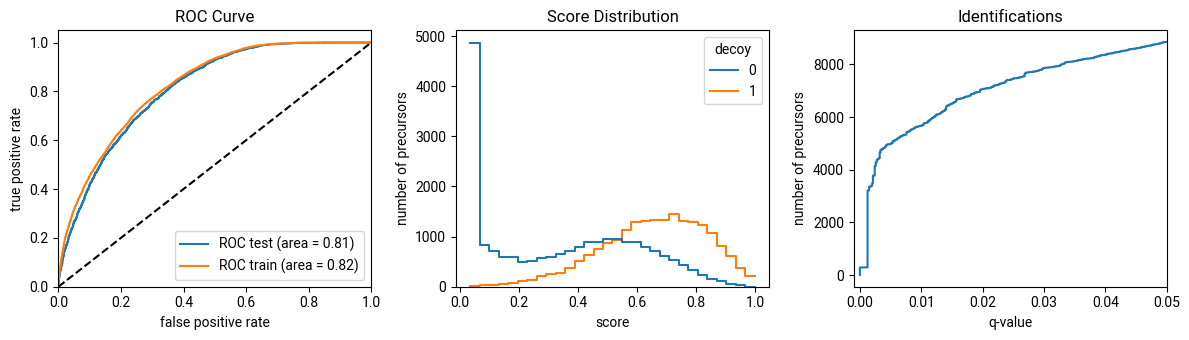

2022-11-29 23:23:42> Found 5,673 features with qval < 0.01
2022-11-29 23:23:42> Performing calibration with 5673 features


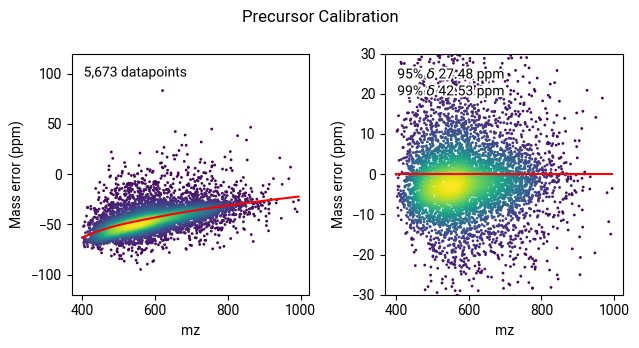

2022-11-29 23:23:42> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:23:42> Performing calibration with 10000 features


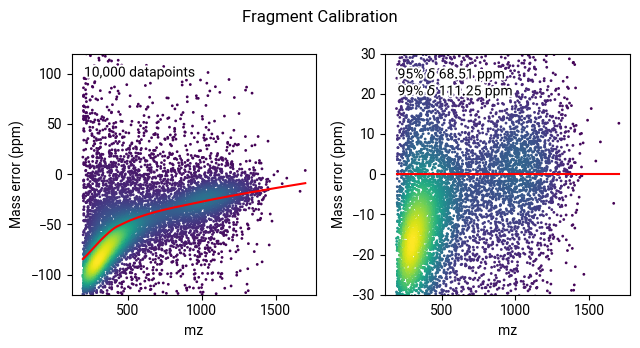

2022-11-29 23:23:44> Ending iteration 0, 70% MS1 error 9.40 ppm, 70% MS2 error 24.44 ppm
2022-11-29 23:23:44> Starting Iteration 1, MS1 error 72.00 ppm, MS2 error 72.00 ppm
2022-11-29 23:23:50> Performing precursor_mz calibration
2022-11-29 23:23:50> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:38<00:00, 1147.37it/s]


2022-11-29 23:24:29> performing MS2 extraction for 41,755 candidates


100%|██████████| 41755/41755 [00:18<00:00, 2277.42it/s]


2022-11-29 23:24:48> MS2 extraction was able to extract 40,888 sets of features for 97.92% of candidates


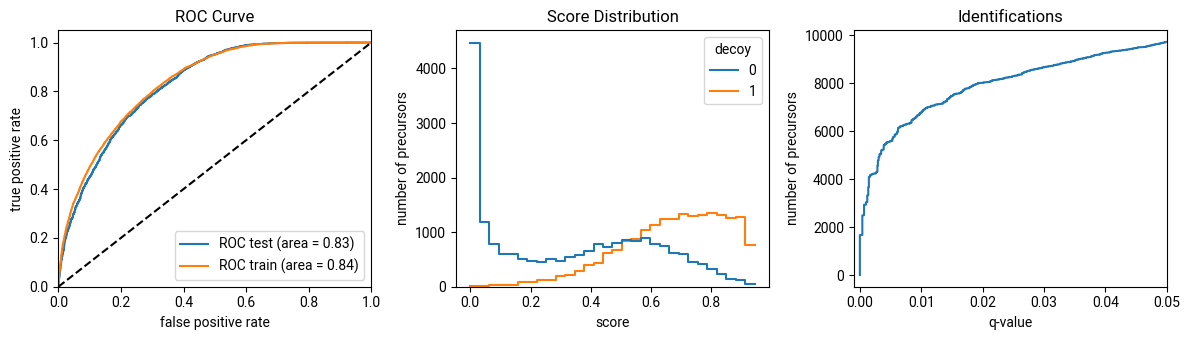

2022-11-29 23:25:07> Found 6,777 features with qval < 0.01
2022-11-29 23:25:07> Performing calibration with 6777 features


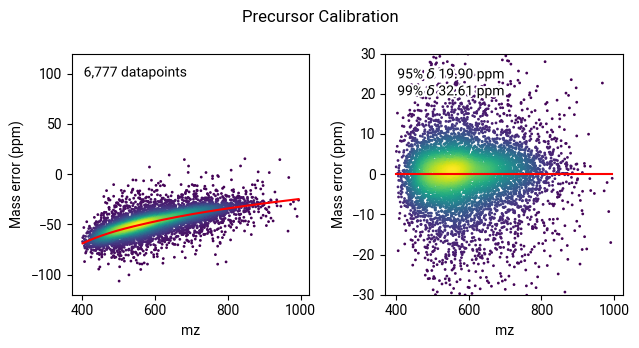

2022-11-29 23:25:08> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:25:08> Performing calibration with 10000 features


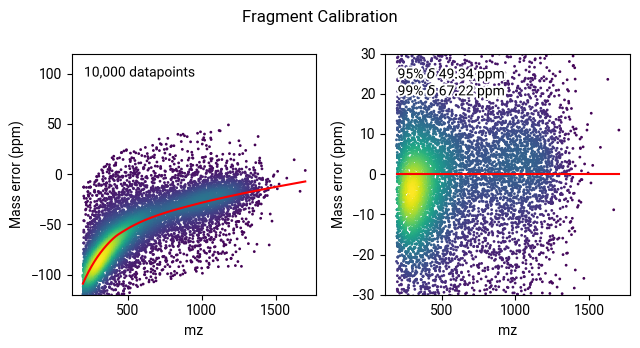

2022-11-29 23:25:09> Ending iteration 1, 70% MS1 error 7.16 ppm, 70% MS2 error 17.59 ppm
2022-11-29 23:25:09> Starting Iteration 2, MS1 error 43.20 ppm, MS2 error 43.20 ppm
2022-11-29 23:25:16> Performing precursor_mz calibration
2022-11-29 23:25:16> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:38<00:00, 1125.06it/s]


2022-11-29 23:25:55> performing MS2 extraction for 40,643 candidates


100%|██████████| 40643/40643 [00:17<00:00, 2280.48it/s]


2022-11-29 23:26:13> MS2 extraction was able to extract 39,660 sets of features for 97.58% of candidates


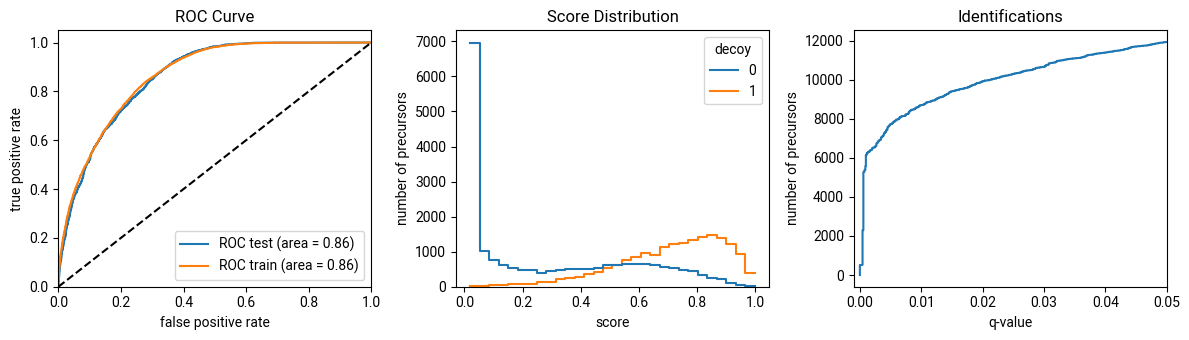

2022-11-29 23:26:40> Found 8,699 features with qval < 0.01
2022-11-29 23:26:40> Performing calibration with 8699 features


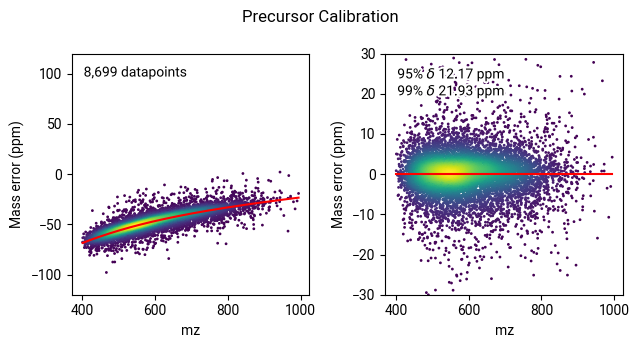

2022-11-29 23:26:41> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:26:41> Performing calibration with 10000 features


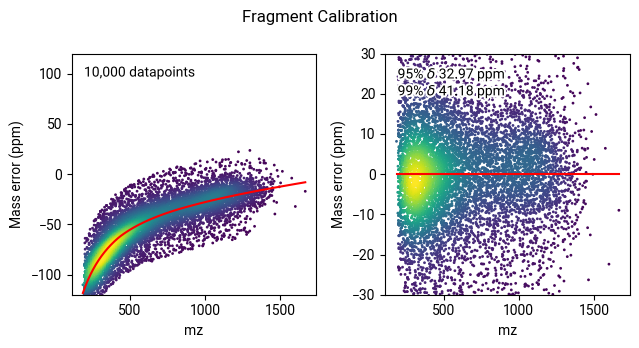

2022-11-29 23:26:42> Ending iteration 2, 70% MS1 error 4.63 ppm, 70% MS2 error 12.91 ppm
2022-11-29 23:26:42> Starting Iteration 3, MS1 error 25.92 ppm, MS2 error 25.92 ppm
2022-11-29 23:26:49> Performing precursor_mz calibration
2022-11-29 23:26:49> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:36<00:00, 1196.14it/s]


2022-11-29 23:27:26> performing MS2 extraction for 39,027 candidates


100%|██████████| 39027/39027 [00:17<00:00, 2285.46it/s]


2022-11-29 23:27:44> MS2 extraction was able to extract 37,827 sets of features for 96.93% of candidates


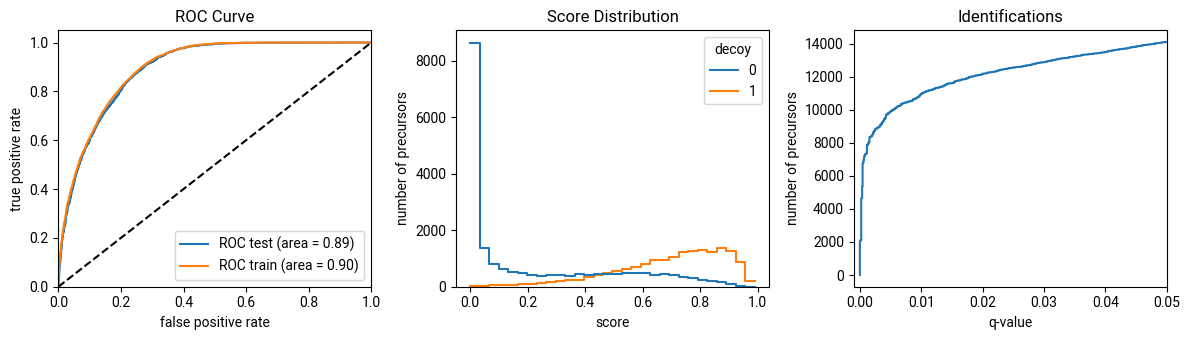

2022-11-29 23:28:02> Found 10,928 features with qval < 0.01
2022-11-29 23:28:02> Performing calibration with 10928 features


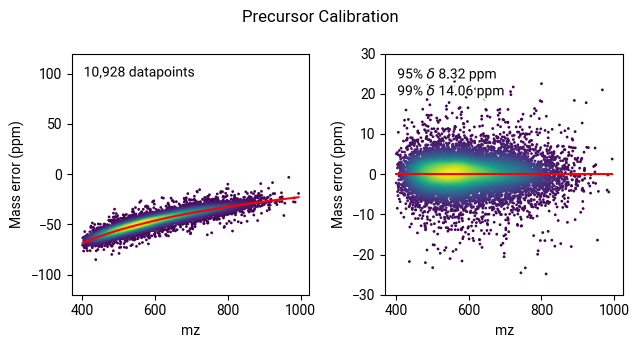

2022-11-29 23:28:04> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:28:04> Performing calibration with 10000 features


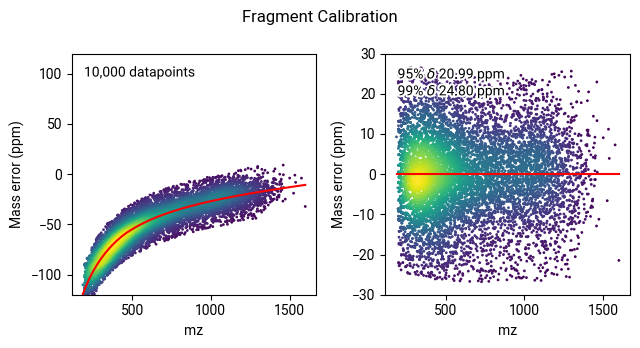

2022-11-29 23:28:05> Ending iteration 3, 70% MS1 error 3.44 ppm, 70% MS2 error 10.48 ppm
2022-11-29 23:28:05> Starting Iteration 4, MS1 error 15.55 ppm, MS2 error 15.55 ppm
2022-11-29 23:28:12> Performing precursor_mz calibration
2022-11-29 23:28:12> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:36<00:00, 1193.73it/s]


2022-11-29 23:28:49> performing MS2 extraction for 36,789 candidates


100%|██████████| 36789/36789 [00:16<00:00, 2273.99it/s]


2022-11-29 23:29:06> MS2 extraction was able to extract 35,450 sets of features for 96.36% of candidates


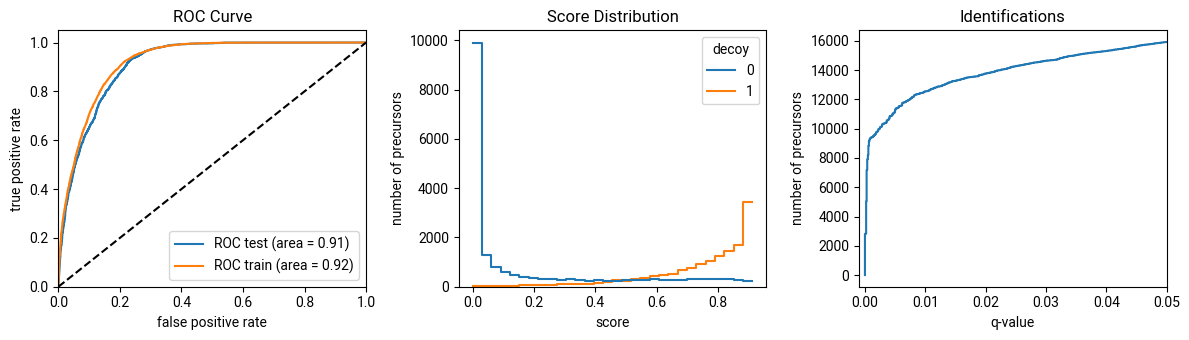

2022-11-29 23:29:23> Found 12,542 features with qval < 0.01
2022-11-29 23:29:23> Performing calibration with 12542 features


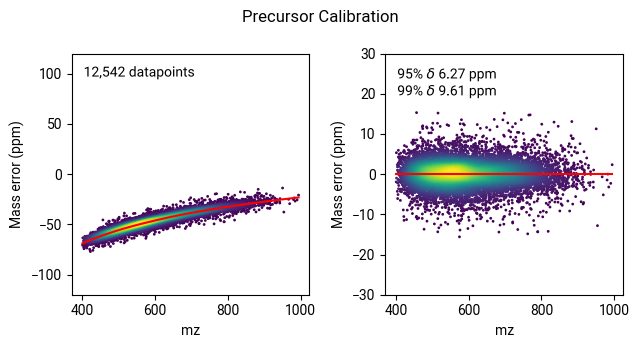

2022-11-29 23:29:24> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:29:24> Performing calibration with 10000 features


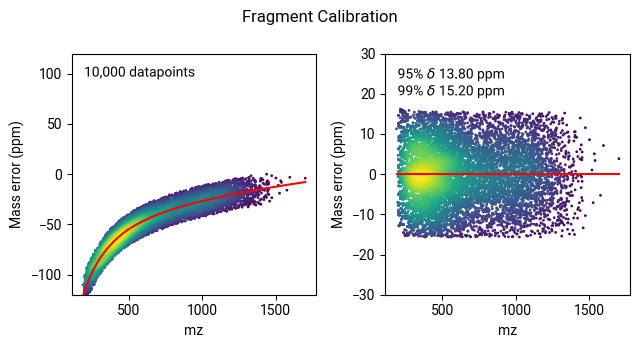

2022-11-29 23:29:25> Ending iteration 4, 70% MS1 error 2.75 ppm, 70% MS2 error 8.36 ppm
2022-11-29 23:29:25> Starting Iteration 5, MS1 error 9.33 ppm, MS2 error 9.33 ppm
2022-11-29 23:29:32> Performing precursor_mz calibration
2022-11-29 23:29:32> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:35<00:00, 1226.65it/s]


2022-11-29 23:30:08> performing MS2 extraction for 33,986 candidates


100%|██████████| 33986/33986 [00:14<00:00, 2296.70it/s]


2022-11-29 23:30:24> MS2 extraction was able to extract 32,267 sets of features for 94.94% of candidates


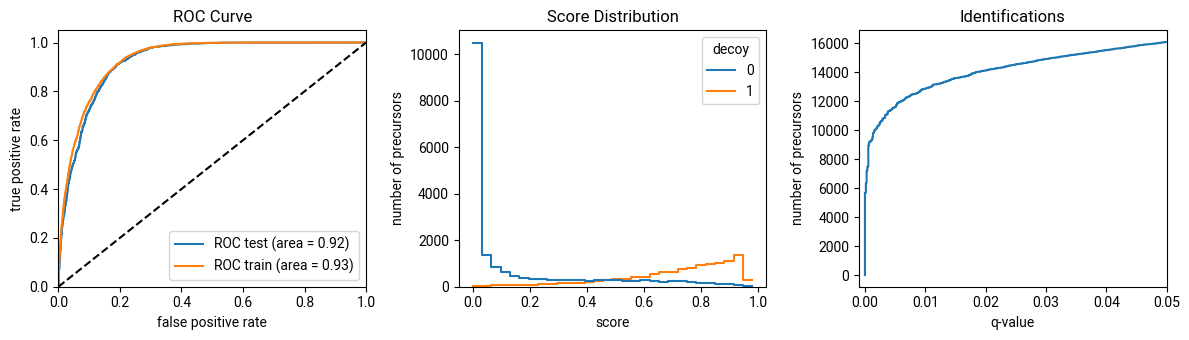

2022-11-29 23:30:42> Found 12,873 features with qval < 0.01
2022-11-29 23:30:42> Performing calibration with 12873 features


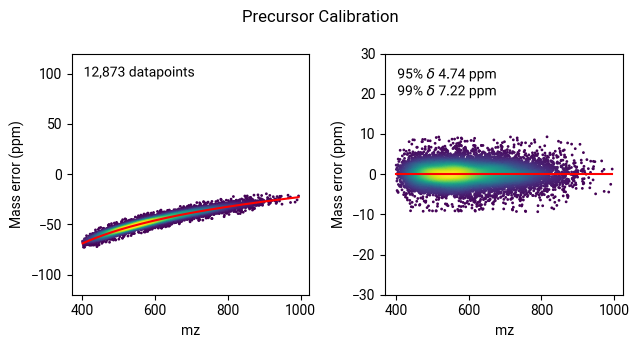

2022-11-29 23:30:44> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:30:44> Performing calibration with 10000 features


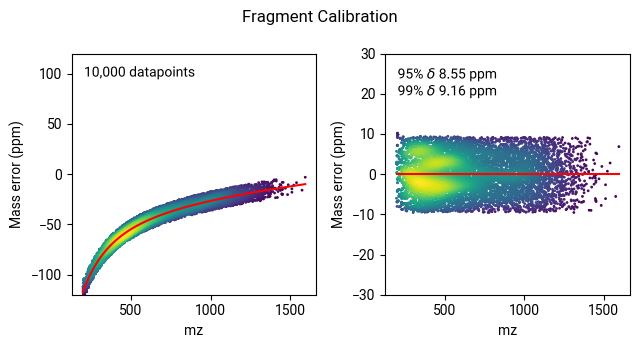

2022-11-29 23:30:45> Ending iteration 5, 70% MS1 error 2.22 ppm, 70% MS2 error 5.54 ppm
2022-11-29 23:30:45> Starting Iteration 6, MS1 error 5.60 ppm, MS2 error 8.00 ppm
2022-11-29 23:30:52> Performing precursor_mz calibration
2022-11-29 23:30:52> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:35<00:00, 1221.58it/s]


2022-11-29 23:31:28> performing MS2 extraction for 30,359 candidates


100%|██████████| 30359/30359 [00:13<00:00, 2233.11it/s]


2022-11-29 23:31:42> MS2 extraction was able to extract 28,860 sets of features for 95.06% of candidates


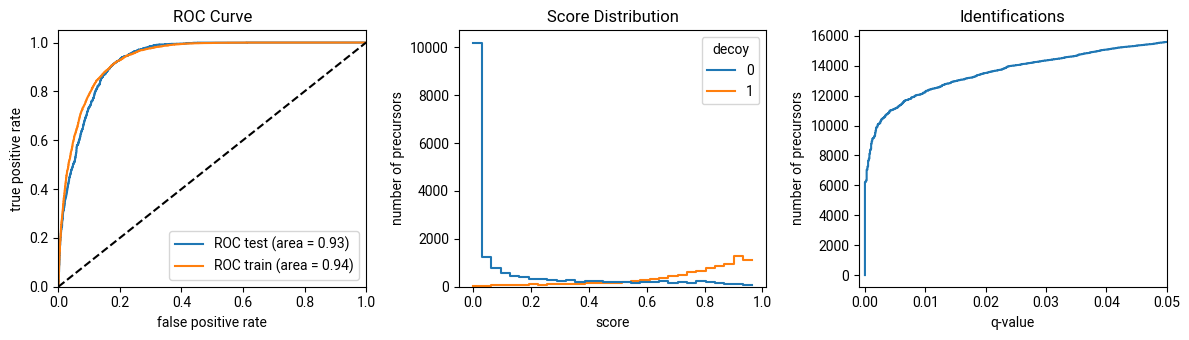

2022-11-29 23:31:56> Found 12,239 features with qval < 0.01
2022-11-29 23:31:56> Performing calibration with 12239 features


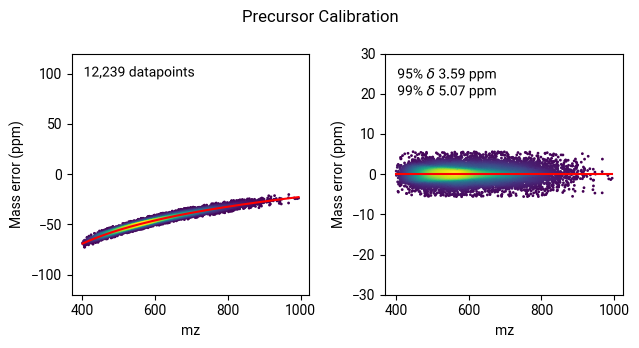

2022-11-29 23:31:58> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:31:58> Performing calibration with 10000 features


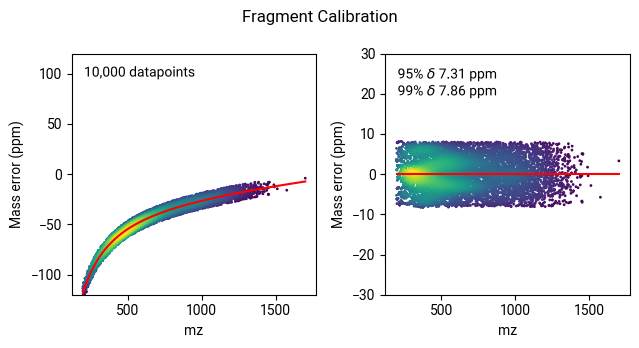

2022-11-29 23:31:59> Ending iteration 6, 70% MS1 error 1.61 ppm, 70% MS2 error 4.75 ppm
2022-11-29 23:31:59> Starting Iteration 7, MS1 error 5.00 ppm, MS2 error 8.00 ppm
2022-11-29 23:32:06> Performing precursor_mz calibration
2022-11-29 23:32:06> Performing fragment_mz calibration


100%|██████████| 43733/43733 [00:35<00:00, 1236.59it/s]


2022-11-29 23:32:42> performing MS2 extraction for 29,343 candidates


100%|██████████| 29343/29343 [00:12<00:00, 2300.83it/s]


2022-11-29 23:32:55> MS2 extraction was able to extract 27,929 sets of features for 95.18% of candidates


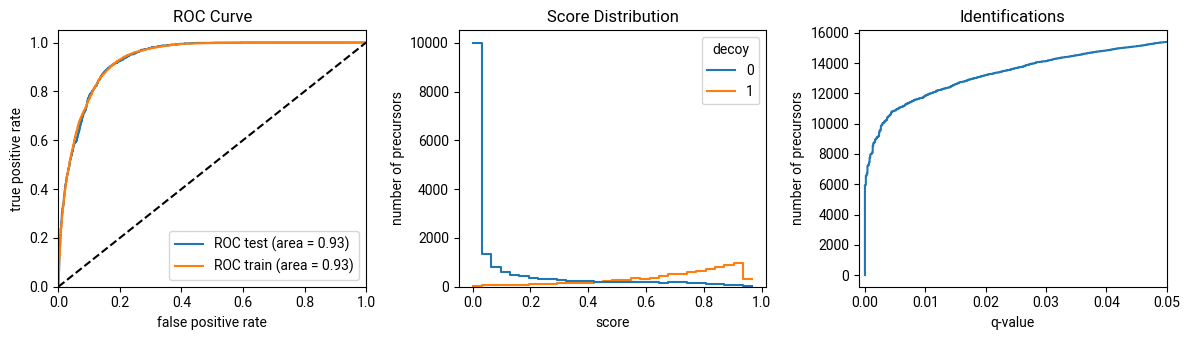

2022-11-29 23:33:08> Found 11,852 features with qval < 0.01
2022-11-29 23:33:08> Performing calibration with 11852 features


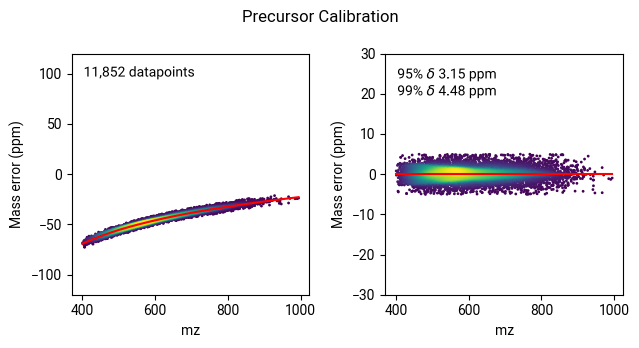

2022-11-29 23:33:09> Performing calibration for run 0 with 10000 fragments
2022-11-29 23:33:09> Performing calibration with 10000 features


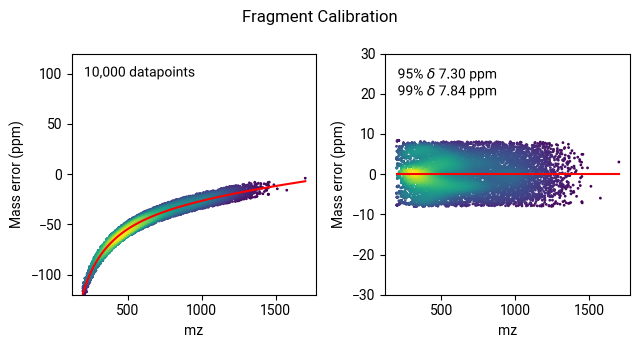

2022-11-29 23:33:10> Ending iteration 7, 70% MS1 error 1.47 ppm, 70% MS2 error 4.78 ppm
2022-11-29 23:33:10> Ending iteration 7, target_reached
2022-11-29 23:33:10> Importing data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d
2022-11-29 23:33:10> Using .d import for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d
2022-11-29 23:33:10> Reading frame metadata for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d
2022-11-29 23:33:11> Reading 19,874 frames with 711,188,147 detector events for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d


100%|██████████| 19874/19874 [00:03<00:00, 5747.45it/s]

2022-11-29 23:33:14> Indexing /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d...
2022-11-29 23:33:14> Bruker DLL not available, estimating mobility values
2022-11-29 23:33:14> WARNING: Acquisition software is Bruker otofControl, mz min/max values are assumed to be 5 m/z wider than defined in analysis.tdf!
2022-11-29 23:33:14> Bruker DLL not available, estimating mz values
2022-11-29 23:33:14> Indexing quadrupole dimension


2022-11-29 23:33:14> Successfully imported data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D3_1_2946.d
2022-11-29 23:33:14> Initializing class njit functions
2022-11-29 23:33:15> Starting Iteration 0, MS1 error 120.00 ppm, MS2 error 120.00 ppm
2022-11-29 23:33:19> Performing precursor_mz calibration
2022-11-29 23:33:19> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:35<00:00, 1229.62it/s]


2022-11-29 23:33:55> performing MS2 extraction for 42,103 candidates


100%|██████████| 42103/42103 [00:18<00:00, 2285.52it/s]


2022-11-29 23:34:14> MS2 extraction was able to extract 41,271 sets of features for 98.02% of candidates


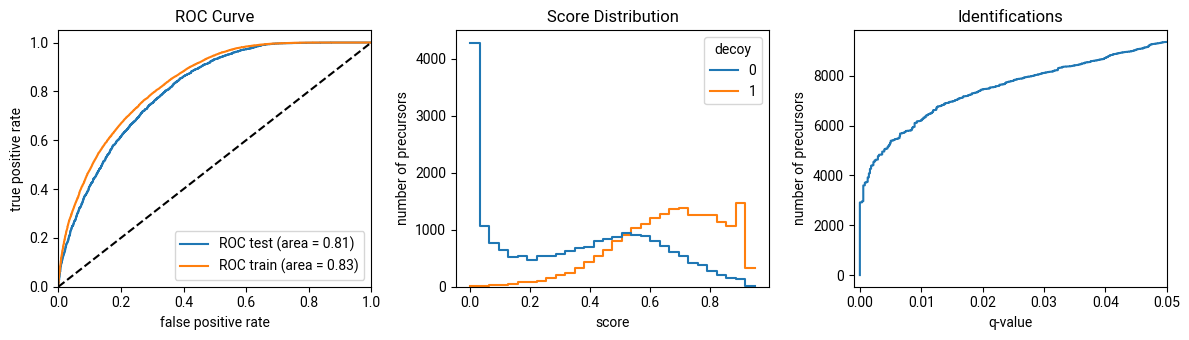

2022-11-29 23:34:40> Found 6,197 features with qval < 0.01
2022-11-29 23:34:40> Performing calibration with 6197 features


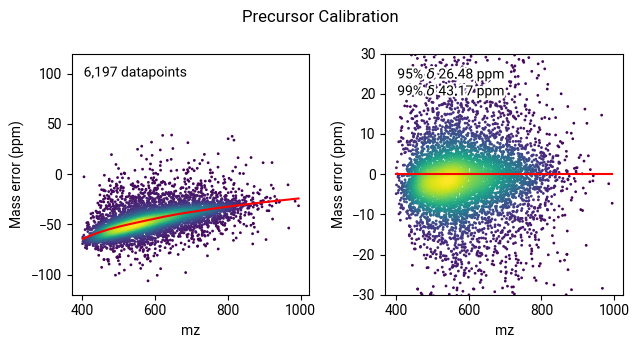

2022-11-29 23:34:41> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:34:41> Performing calibration with 10000 features


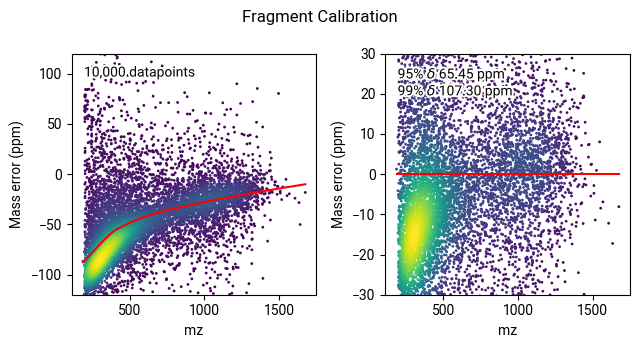

2022-11-29 23:34:42> Ending iteration 0, 70% MS1 error 8.34 ppm, 70% MS2 error 22.71 ppm
2022-11-29 23:34:42> Starting Iteration 1, MS1 error 72.00 ppm, MS2 error 72.00 ppm
2022-11-29 23:34:46> Performing precursor_mz calibration
2022-11-29 23:34:46> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:34<00:00, 1273.58it/s]


2022-11-29 23:35:21> performing MS2 extraction for 41,527 candidates


100%|██████████| 41527/41527 [00:18<00:00, 2285.55it/s]


2022-11-29 23:35:40> MS2 extraction was able to extract 40,633 sets of features for 97.85% of candidates


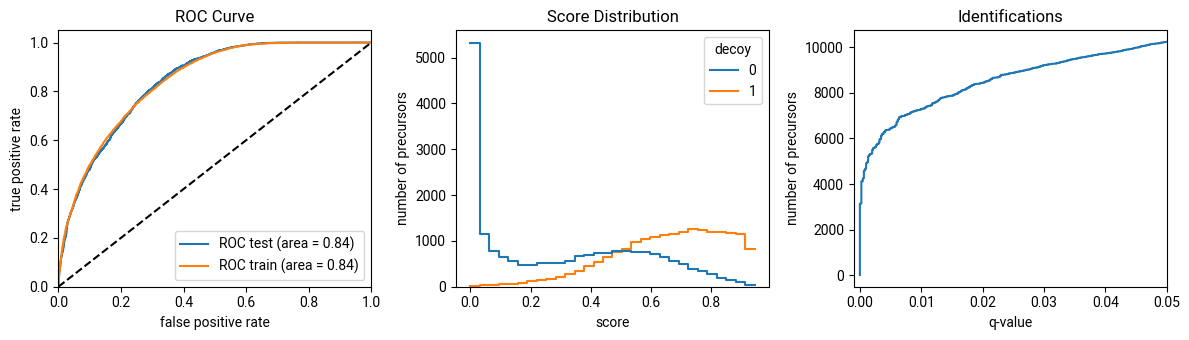

2022-11-29 23:35:58> Found 7,294 features with qval < 0.01
2022-11-29 23:35:58> Performing calibration with 7294 features


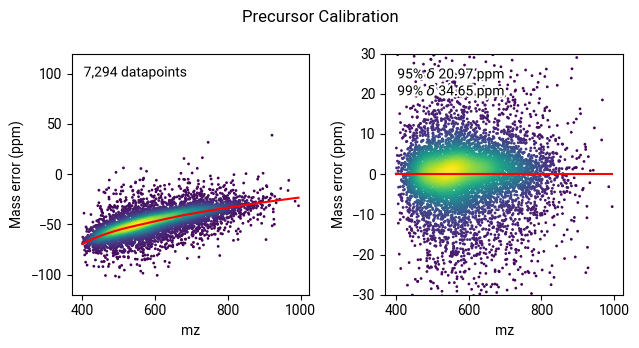

2022-11-29 23:35:58> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:35:58> Performing calibration with 10000 features


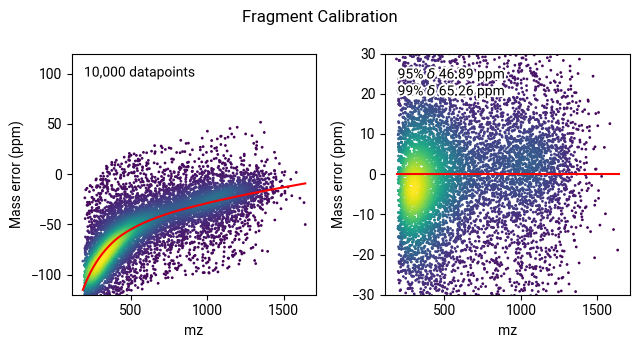

2022-11-29 23:35:59> Ending iteration 1, 70% MS1 error 7.09 ppm, 70% MS2 error 15.90 ppm
2022-11-29 23:35:59> Starting Iteration 2, MS1 error 43.20 ppm, MS2 error 43.20 ppm
2022-11-29 23:36:04> Performing precursor_mz calibration
2022-11-29 23:36:04> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:33<00:00, 1300.55it/s]


2022-11-29 23:36:38> performing MS2 extraction for 40,350 candidates


100%|██████████| 40350/40350 [00:17<00:00, 2291.28it/s]


2022-11-29 23:36:56> MS2 extraction was able to extract 39,351 sets of features for 97.52% of candidates


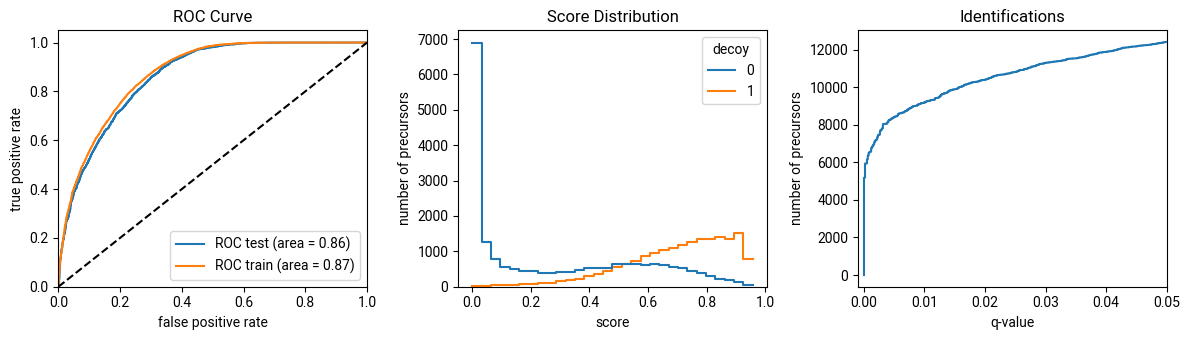

2022-11-29 23:37:15> Found 9,176 features with qval < 0.01
2022-11-29 23:37:15> Performing calibration with 9176 features


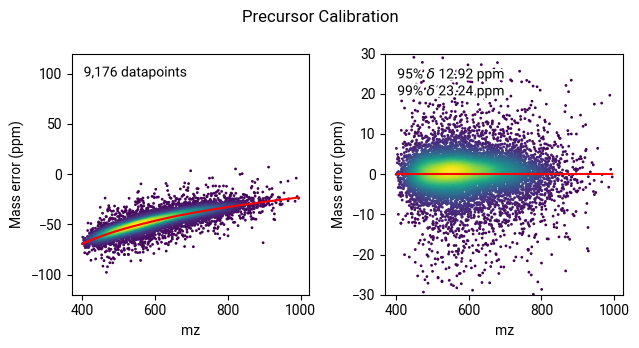

2022-11-29 23:37:16> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:37:16> Performing calibration with 10000 features


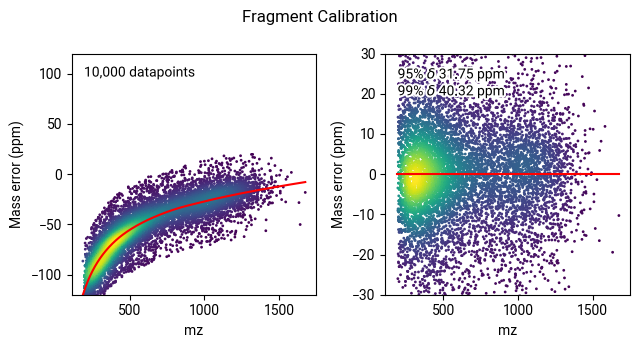

2022-11-29 23:37:17> Ending iteration 2, 70% MS1 error 4.38 ppm, 70% MS2 error 12.30 ppm
2022-11-29 23:37:17> Starting Iteration 3, MS1 error 25.92 ppm, MS2 error 25.92 ppm
2022-11-29 23:37:21> Performing precursor_mz calibration
2022-11-29 23:37:21> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:33<00:00, 1306.42it/s]


2022-11-29 23:37:55> performing MS2 extraction for 38,667 candidates


100%|██████████| 38667/38667 [00:16<00:00, 2294.96it/s]


2022-11-29 23:38:13> MS2 extraction was able to extract 37,515 sets of features for 97.02% of candidates


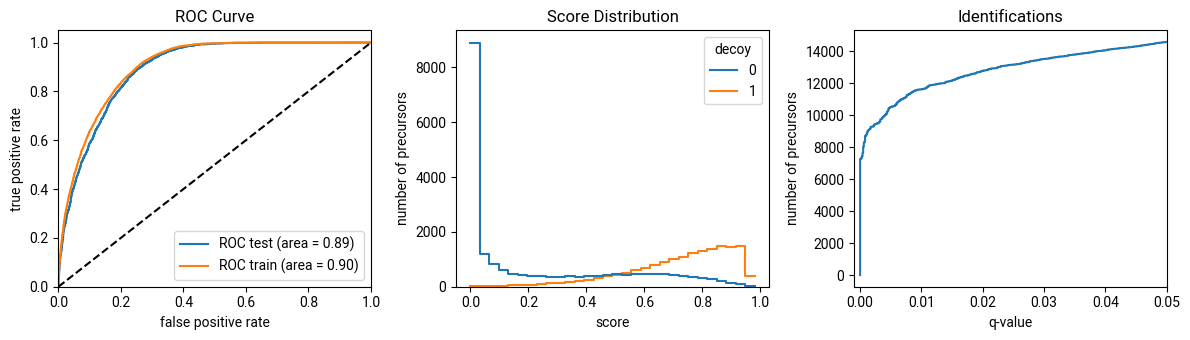

2022-11-29 23:38:32> Found 11,627 features with qval < 0.01
2022-11-29 23:38:32> Performing calibration with 11627 features


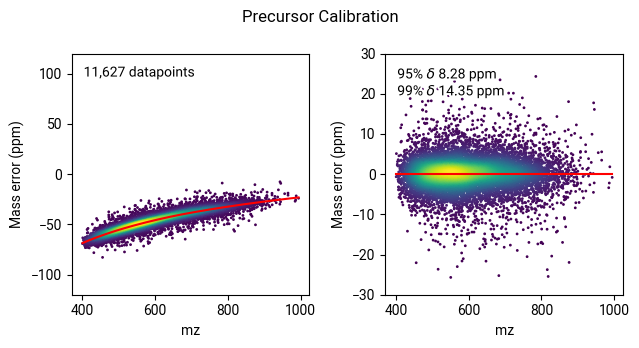

2022-11-29 23:38:33> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:38:33> Performing calibration with 10000 features


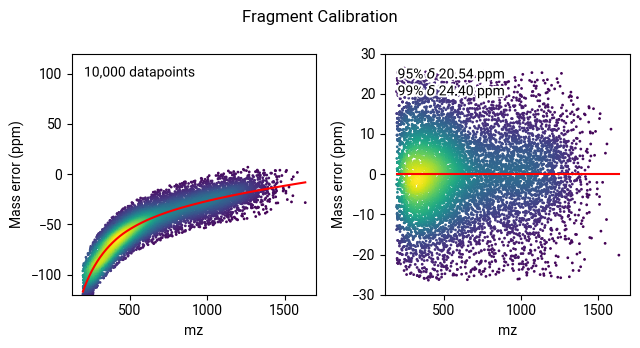

2022-11-29 23:38:34> Ending iteration 3, 70% MS1 error 3.28 ppm, 70% MS2 error 10.39 ppm
2022-11-29 23:38:34> Starting Iteration 4, MS1 error 15.55 ppm, MS2 error 15.55 ppm
2022-11-29 23:38:39> Performing precursor_mz calibration
2022-11-29 23:38:39> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:32<00:00, 1347.73it/s]


2022-11-29 23:39:12> performing MS2 extraction for 36,528 candidates


100%|██████████| 36528/36528 [00:15<00:00, 2293.12it/s]


2022-11-29 23:39:28> MS2 extraction was able to extract 35,189 sets of features for 96.33% of candidates


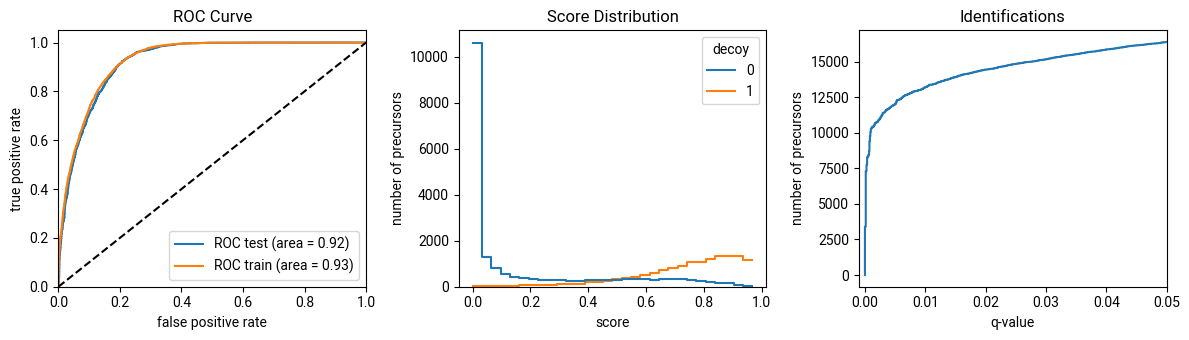

2022-11-29 23:39:42> Found 13,180 features with qval < 0.01
2022-11-29 23:39:42> Performing calibration with 13180 features


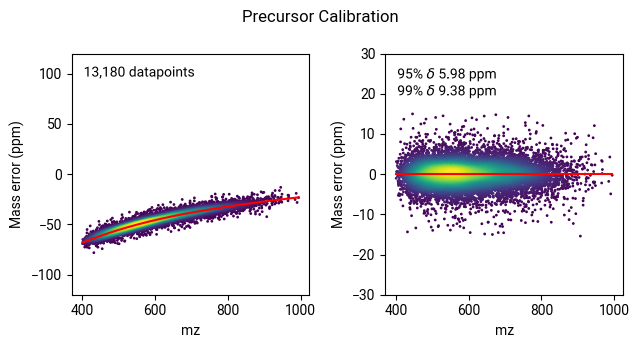

2022-11-29 23:39:44> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:39:44> Performing calibration with 10000 features


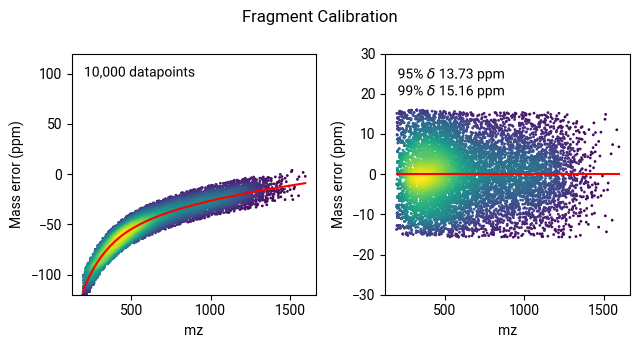

2022-11-29 23:39:45> Ending iteration 4, 70% MS1 error 2.68 ppm, 70% MS2 error 8.18 ppm
2022-11-29 23:39:45> Starting Iteration 5, MS1 error 9.33 ppm, MS2 error 9.33 ppm
2022-11-29 23:39:50> Performing precursor_mz calibration
2022-11-29 23:39:50> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:32<00:00, 1363.72it/s]


2022-11-29 23:40:22> performing MS2 extraction for 33,836 candidates


100%|██████████| 33836/33836 [00:14<00:00, 2274.14it/s]


2022-11-29 23:40:38> MS2 extraction was able to extract 32,267 sets of features for 95.36% of candidates


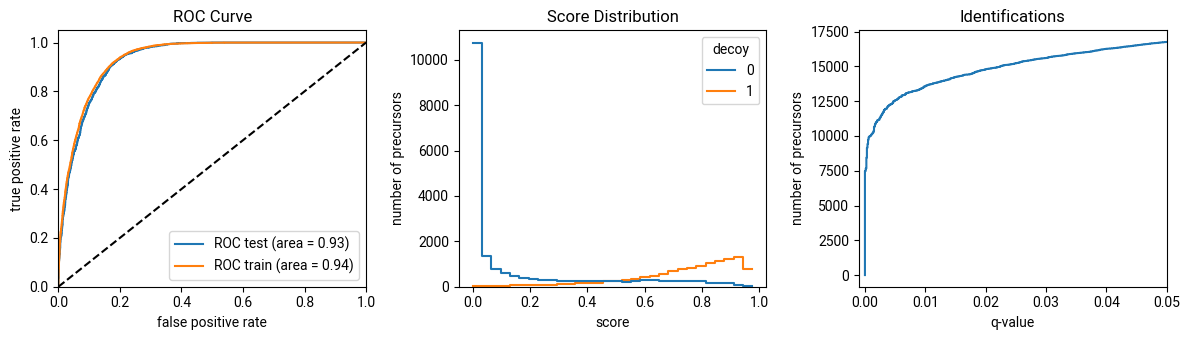

2022-11-29 23:41:09> Found 13,560 features with qval < 0.01
2022-11-29 23:41:09> Performing calibration with 13560 features


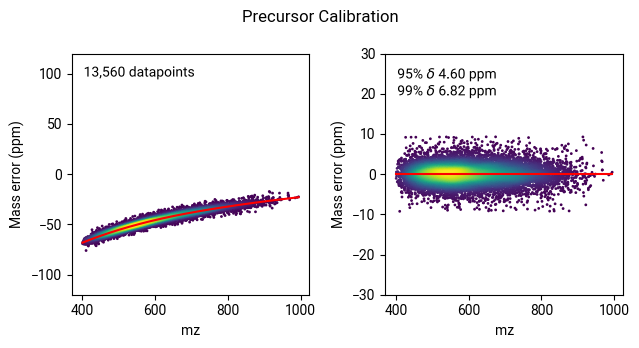

2022-11-29 23:41:12> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:41:12> Performing calibration with 10000 features


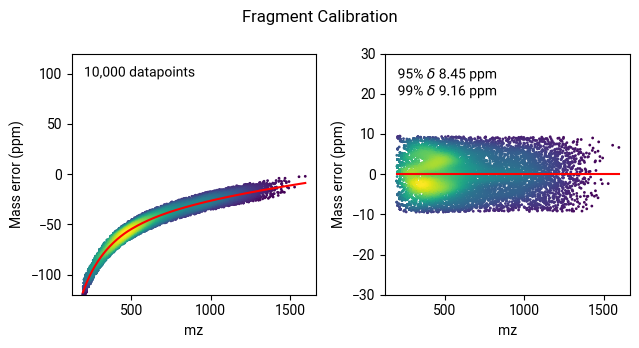

2022-11-29 23:41:13> Ending iteration 5, 70% MS1 error 2.12 ppm, 70% MS2 error 5.38 ppm
2022-11-29 23:41:13> Starting Iteration 6, MS1 error 5.60 ppm, MS2 error 8.00 ppm
2022-11-29 23:41:17> Performing precursor_mz calibration
2022-11-29 23:41:17> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:32<00:00, 1352.82it/s]


2022-11-29 23:41:50> performing MS2 extraction for 30,575 candidates


100%|██████████| 30575/30575 [00:13<00:00, 2321.17it/s]


2022-11-29 23:42:04> MS2 extraction was able to extract 29,206 sets of features for 95.52% of candidates


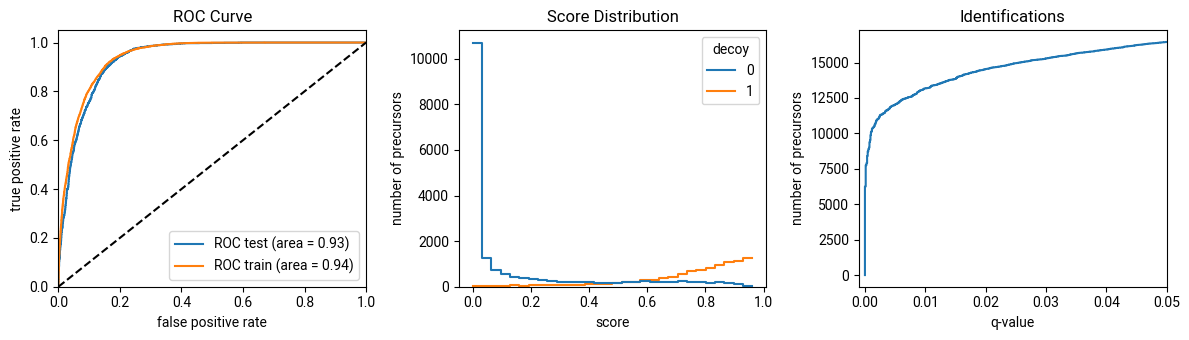

2022-11-29 23:42:26> Found 13,172 features with qval < 0.01
2022-11-29 23:42:26> Performing calibration with 13172 features


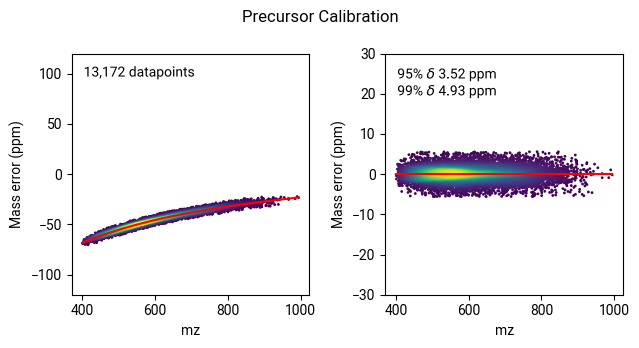

2022-11-29 23:42:28> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:42:28> Performing calibration with 10000 features


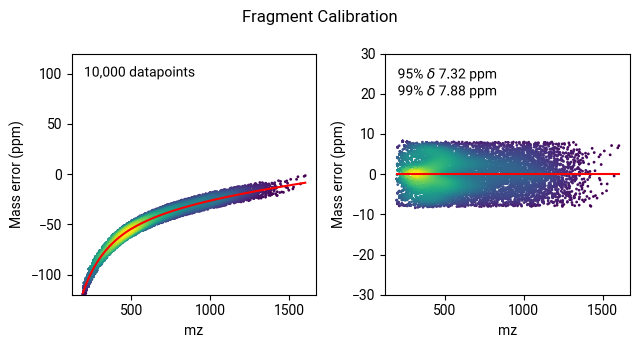

2022-11-29 23:42:29> Ending iteration 6, 70% MS1 error 1.54 ppm, 70% MS2 error 4.75 ppm
2022-11-29 23:42:29> Starting Iteration 7, MS1 error 5.00 ppm, MS2 error 8.00 ppm
2022-11-29 23:42:33> Performing precursor_mz calibration
2022-11-29 23:42:33> Performing fragment_mz calibration


100%|██████████| 43732/43732 [00:32<00:00, 1356.82it/s]


2022-11-29 23:43:06> performing MS2 extraction for 29,701 candidates


100%|██████████| 29701/29701 [00:12<00:00, 2323.43it/s]


2022-11-29 23:43:19> MS2 extraction was able to extract 28,444 sets of features for 95.77% of candidates


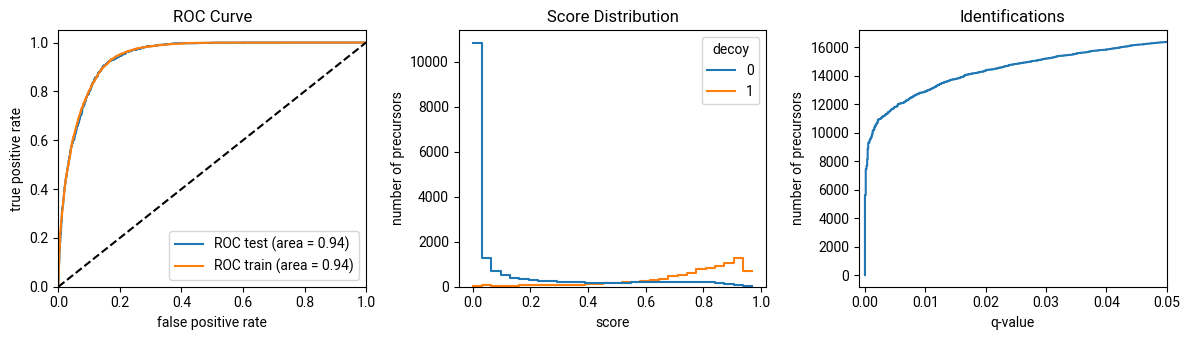

2022-11-29 23:43:35> Found 12,869 features with qval < 0.01
2022-11-29 23:43:35> Performing calibration with 12869 features


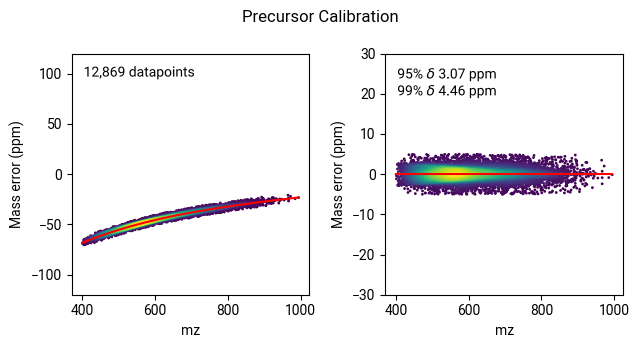

2022-11-29 23:43:36> Performing calibration for run 1 with 10000 fragments
2022-11-29 23:43:36> Performing calibration with 10000 features


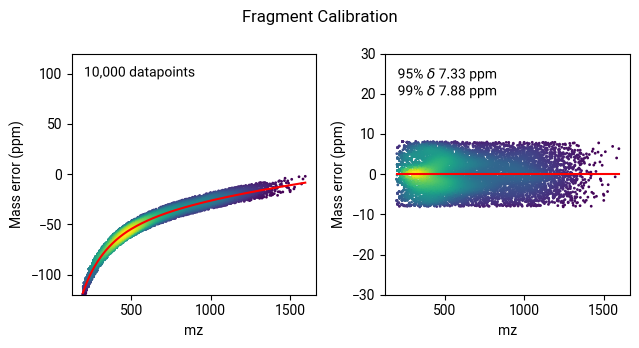

2022-11-29 23:43:37> Ending iteration 7, 70% MS1 error 1.44 ppm, 70% MS2 error 4.68 ppm
2022-11-29 23:43:37> Ending iteration 7, target_reached


In [77]:
profiling = []

for run in extraction_plan.runs:
    dia_data = TimsTOFDIA(run['path'])

    initial_ms1_error = 120
    initial_ms2_error = 120

    target_ms1_error = 5
    target_ms2_error = 8

    iteration = 0
    while initial_ms1_error >= target_ms1_error or iteration < 10:
        logging.info(f'Starting Iteration {iteration}, MS1 error {initial_ms1_error:.2f} ppm, MS2 error {initial_ms2_error:.2f} ppm')
        precursors_flat, fragments_flat = extraction_plan.build_run_precursor_df(run['index'])

        if iteration == 0:
            mz_column = 'mz_predicted'
        else:
            mz_column = 'mz_calibrated'
    
        extraction = MS1CentricCandidateSelection(
            dia_data,
            precursors_flat, 
            rt_column = 'rt_observed',  
            mobility_column = 'mobility_observed',
            precursor_mz_column = mz_column,
            rt_tolerance=15,
            mobility_tolerance=0.02,
            num_candidates=1,
            num_isotopes=3,
            mz_tolerance=initial_ms1_error,
        )
        candidates_df = extraction()
        candidates_filtered = candidates_df[candidates_df['fraction_nonzero'] > 0]
        extraction = MS2ExtractionWorkflow(
            dia_data,
            precursors_flat, 
            candidates_filtered,
            fragments_flat,
            coarse_mz_calibration = False,
            rt_column = 'rt_observed',
            mobility_column = 'mobility_observed',
            precursor_mz_column = mz_column,
            fragment_mz_column = mz_column,
            precursor_mass_tolerance=initial_ms1_error,
            fragment_mass_tolerance=initial_ms2_error,
        )
        features_df = extraction()
        features_df['decoy'] = precursors_flat['decoy'].values[features_df['index'].values]
        features_df['charge'] = precursors_flat['charge'].values[features_df['index'].values]
        features_df['nAA'] = precursors_flat['nAA'].values[features_df['index'].values]
        features_df = fdr_correction(features_df)

        feature_filtered = features_df[features_df['qval'] < 0.01]
        logging.info(f'Found {len(feature_filtered):,} features with qval < 0.01')

        # recalibrate
        extraction_plan.calibration.estimators[run['index']]['precursor_mz'] = LOESSRegression(n_kernels=3, polynomial_degree=2, kernel_size=2)
        m1_70, m1_95, m1_99 = recalibrate_mz(feature_filtered, extraction_plan.calibration.estimators[run['index']]['precursor_mz'], plot_title=f'Precursor Calibration')

        fragment_calibration_df = alphadia.extraction.scoring.unpack_fragment_info(feature_filtered)
        fragment_calibration_df = fragment_calibration_df.sort_values(by=['intensity'], ascending=True).head(10000)
        logging.info(f"Performing calibration for run {run['index']} with {len(fragment_calibration_df)} fragments")
        extraction_plan.calibration.estimators[run['index']]['fragment_mz'] = LOESSRegression(n_kernels=3, polynomial_degree=2, kernel_size=2)
        m2_70, m2_95, m2_99 = recalibrate_mz(fragment_calibration_df, extraction_plan.calibration.estimators[run['index']]['fragment_mz'], plot_title=f'Fragment Calibration')

        logging.info(f'Ending iteration {iteration}, 70% MS1 error {m1_70:.2f} ppm, 70% MS2 error {m2_70:.2f} ppm')

        profiling.append({
            'run': run['index'],
            'iteration': iteration,
            'ids': len(feature_filtered),
            'ms1_tol': initial_ms1_error,
            'ms2_tol': initial_ms2_error,
            'ms1_70': m1_70,
            'ms1_95': m1_95,
            'ms1_99': m1_99,
            'ms2_70': m2_70,
            'ms2_95': m2_95,
            'ms2_99': m2_99,
        })

        if initial_ms1_error == target_ms1_error and initial_ms2_error == target_ms2_error:
            logging.info(f'Ending iteration {iteration}, target_reached')
            break

        initial_ms1_error = max(m1_70, target_ms1_error, initial_ms1_error * 0.6)
        initial_ms2_error = max(m2_70, target_ms2_error, initial_ms2_error * 0.6)

        iteration += 1





In [78]:
profiling_df = pd.DataFrame(profiling)
profiling_df

run  iteration    ids    ms1_tol   ms2_tol    ms1_70     ms1_95  \
0     0          0   5673  120.00000  120.0000  9.395590  27.477930   
1     0          1   6777   72.00000   72.0000  7.159184  19.903434   
2     0          2   8699   43.20000   43.2000  4.634350  12.167350   
3     0          3  10928   25.92000   25.9200  3.441962   8.324630   
4     0          4  12542   15.55200   15.5520  2.747592   6.266831   
5     0          5  12873    9.33120    9.3312  2.215873   4.737427   
6     0          6  12239    5.59872    8.0000  1.607027   3.588422   
7     0          7  11852    5.00000    8.0000  1.473211   3.153968   
8     1          0   6197  120.00000  120.0000  8.335142  26.477573   
9     1          1   7294   72.00000   72.0000  7.088415  20.970867   
10    1          2   9176   43.20000   43.2000  4.375014  12.918537   
11    1          3  11627   25.92000   25.9200  3.282253   8.275493   
12    1          4  13180   15.55200   15.5520  2.676851   5.982569   
13    1          5  13560    9.33120    9.3312  2.119648   4.598845   
14    1          6  13172    5.59872    8.0000  1.544716   3.516440   
15    1          7  12869    5.00000    8.0000  1.441655   3.065901   

       ms1_99     ms2_70     ms2_95      ms2_99  
0   42.530441  24.444315  68.508431  111.246891  
1   32.611320  17.589818  49.343163   67.219417  
2   21.931733  12.910601  32.965403   41.184739  
3   14.063207  10.480996  20.990945   24.801355  
4    9.612268   8.360476  13.797305   15.202951  
5    7.220293   5.541618   8.546516    9.160856  
6    5.071149   4.754553   7.309379    7.861103  
7    4.475457   4.776211   7.295342    7.843460  
8   43.171887  22.714540  65.446795  107.301186  
9   34.647677  15.899848  46.892277   65.260159  
10  23.244311  12.301698  31.747753   40.320976  
11  14.346271  10.386041  20.537127   24.395045  
12   9.382872   8.184631  13.725836   15.164907  
13   6.822579   5.384687   8.450791    9.155434  
14   4.929140   4.747720   7.319362    7.884489  
15   4.458827   4.679660   7.332672    7.882060

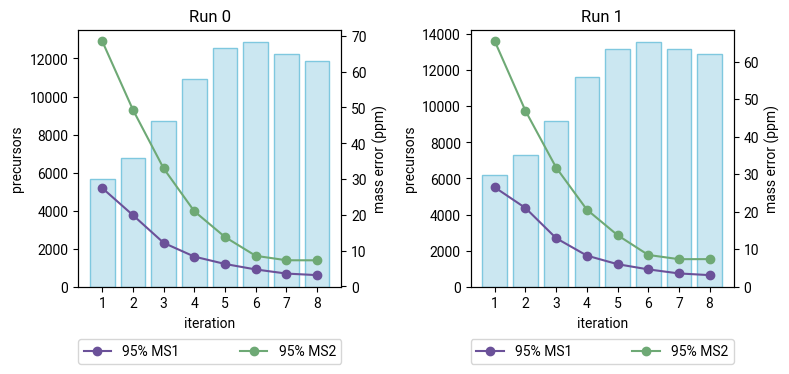

In [79]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 4.))

for i, run in enumerate(profiling_df['run'].unique()):
    run_df = profiling_df[profiling_df['run'] == run]

    
    sns.barplot(data=run_df+1, x='iteration', y='ids', edgecolor='#7fc8df', facecolor='#cbe7f1', ax=axs[i])
    twin = axs[i].twinx()
    twin.plot(run_df['iteration'], run_df['ms1_95'], color='#6b5199', marker='o', label='95% MS1')
    twin.plot(run_df['iteration'], run_df['ms2_95'], color='#6ea975', marker='o', label='95% MS2')

    axs[i].set_title(f'Run {run}')
    axs[i].set_ylabel('precursors')
    axs[i].set_xlabel('iteration')

    twin.set_ylabel('mass error (ppm)')
    twin.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc='lower left',
                        ncol=2, mode="expand", borderaxespad=0.)
fig.tight_layout()

fig.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2022_11_25_calibration_workflow/performance2.png', dpi=300)